In [1]:
            # v v v v vv v v v v v v v v v v v vv v v v v v v v v v v v vv v v v v v v v v v v v vv v v v v #
            # How do NWS point forecasts (PFM) and grid forecasts measure up: are they similar to averages? #
            # ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ #

In [2]:
import pandas as pd
import json
import requests
import re
from datetime import datetime
import geopy
import sys
import os
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from datetime import datetime
import numpy as np
import folium
from sklearn.metrics import mean_squared_error
from IPython.display import display_html
import geopandas
from shapely import wkt
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import NWSPPFunctions as parsfunc
import forecast_merger as merg
import nws

In [4]:
# Collect the PFM with the coordinates of the place you need
# Run this code just once
apistarturl = 'https://api.weather.gov'
PFM = parsfunc.get_api_products(29.9511,-90.0715)
product_json = parsfunc.returnthree_hr_timeseries_json_from_pfm(PFM)

{'productCode': 'PFM', 'productName': 'Point Forecast Matrices'}


In [5]:
product_json

[{'location': '31.18N  90.47W E',
  'start_date': 'Mon 08/01/22 ',
  'pop12H': ['60', '20', '60', '20', '70'],
  'QPF12H': ['  0.21', '  0.04', '  0.09', '     0', '  0.25'],
  'Snow12H': ['00-00', '00-00', '00-00'],
  'timeseries': [[4, '   ', '   ', '   ', '   ', '   ', '   '],
   [7, ' 73', '72 ', '97 ', 'SW ', ' 1 ', 'FW '],
   [10, ' 83', '75 ', '77 ', 'SW ', ' 4 ', 'SC '],
   [13, ' 88', '74 ', '63 ', 'SW ', ' 4 ', 'SC '],
   [16, ' 85', '74 ', '70 ', ' S ', ' 5 ', 'B2 '],
   [19, ' 79', '73 ', '82 ', ' S ', ' 4 ', 'B2 '],
   [22, ' 75', '73 ', '94 ', ' S ', ' 2 ', 'SC '],
   [25, ' 74', '72 ', '93 ', ' S ', ' 2 ', 'SC '],
   [28, ' 73', '72 ', '97 ', 'SW ', ' 1 ', 'SC '],
   [31, ' 73', '72 ', '97 ', 'SW ', ' 1 ', 'SC '],
   [34, ' 82', '75 ', '79 ', 'SW ', ' 4 ', 'B1 '],
   [37, ' 87', '74 ', '65 ', 'SW ', ' 3 ', 'SC '],
   [40, ' 85', '74 ', '70 ', 'SW ', ' 5 ', 'B1 '],
   [43, ' 78', '73 ', '85 ', ' S ', ' 4 ', 'B1 '],
   [46, ' 75', '73 ', '94 ', ' S ', ' 2 ', 'SC '],
   [49

In [6]:
dfpfm = pd.DataFrame(product_json)
cor = dfpfm['location'].tolist()
coords = []

for x in range(0,len(cor)):
    c1 = cor[x].replace('N ',',')
    c2 = c1.replace('W E', '')
    c3 = c2.replace(' ','-')
    coords.append(c3)
    
#In this part we give the coordinates the correct format lat, lon to make the API request of the GRID forecasts

df = pd.DataFrame(coords, columns = ['Coordinates'])
df[['lat','lon']]=df.Coordinates.str.split(',',expand=True)

coords = df.to_dict('index')
df

,Coordinates,lat,lon
0,"31.18,-90.47",31.18,-90.47
1,"30.53,-91.15",30.53,-91.15
2,"30.25,-89.77",30.25,-89.77
3,"30.00,-90.25",30.00,-90.25
4,"30.07,-89.93",30.07,-89.93
5,"30.42,-89.08",30.42,-89.08
6,"30.47,-88.53",30.47,-88.53


In [7]:
m = folium.Map(location=[30.50,-90.0715],zoom_start=8,tiles='Stamen Terrain')

for i in range(0,len(df)):
    folium.Marker(
      location=[df.iloc[i]['lat'], df.iloc[i]['lon']],
      popup=df.iloc[i]['Coordinates'],
   ).add_to(m)
m

In [8]:
# Collect the grid forecasts for the PFM points. If there's a None value in the list, won't be possible to convert to 
# dataframe. That's why the next loop tries to get the forecast untill it succeeds
# Run this code just once
json_forecast = []

for i in range(0,len(coords)):
    
    nwsforecast = None
    
    lat = coords[i]['lat']
    lon = coords[i]['lon']
    
    while nwsforecast == None: 
        nwsforecast = nws.collect_NWS_gridpoint_forecast_from_point(float(lat), float(lon), gridpoints_d=False)
        
        if nwsforecast == None:
            print("It wasn't possible to collect the forecast ", coords[i]['lat'],coords[i]['lat'], "in the position", i)
        else:
            print("The forecast was successfully collected for the coordinates ", coords[i]['lat'],coords[i]['lat'], "in the position", i)

    json_forecast.append(nwsforecast)
    
json_forecast

It wasn't possible to collect the forecast  31.18 31.18 in the position 0
{'type': 'Polygon', 'coordinates': [[[-90.4467206, 31.2172522], [-90.44761190000001, 31.1945594], [-90.4210723, 31.1937946], [-90.42017580000001, 31.2164872], [-90.4467206, 31.2172522]]]}
bad grid: 51/142
It wasn't possible to collect the forecast  31.18 31.18 in the position 0
{'type': 'Polygon', 'coordinates': [[[-90.4467206, 31.2172522], [-90.44761190000001, 31.1945594], [-90.4210723, 31.1937946], [-90.42017580000001, 31.2164872], [-90.4467206, 31.2172522]]]}
bad grid: 51/142
{'type': 'Polygon', 'coordinates': [[[-90.4741402, 31.1953151], [-90.4750256, 31.172629999999998], [-90.44851469999999, 31.1718704], [-90.44762409999998, 31.1945554], [-90.4741402, 31.1953151]]]}
good grid: 50/141
The forecast was successfully collected for the coordinates  31.18 31.18 in the position 0
{'type': 'Polygon', 'coordinates': [[[-91.1328192, 30.5537028], [-91.1335721, 30.5309761], [-91.1071947, 30.5303257], [-91.10643669999999

[{'@context': ['https://geojson.org/geojson-ld/geojson-context.jsonld',
   {'@version': '1.1',
    'wmoUnit': 'https://codes.wmo.int/common/unit/',
    'nwsUnit': 'https://api.weather.gov/ontology/unit/'}],
  'id': 'https://api.weather.gov/gridpoints/LIX/50,141',
  'type': 'Feature',
  'geometry': {'type': 'Polygon',
   'coordinates': [[[-90.4741402, 31.1953151],
     [-90.4750256, 31.172629999999998],
     [-90.44851469999999, 31.1718704],
     [-90.44762409999998, 31.1945554],
     [-90.4741402, 31.1953151]]]},
  'properties': {'@id': 'https://api.weather.gov/gridpoints/LIX/50,141',
   '@type': 'wx:Gridpoint',
   'updateTime': '2022-08-01T14:05:49+00:00',
   'validTimes': '2022-08-01T08:00:00+00:00/P8DT6H',
   'elevation': {'unitCode': 'wmoUnit:m', 'value': 136.8552},
   'forecastOffice': 'https://api.weather.gov/offices/LIX',
   'gridId': 'LIX',
   'gridX': '50',
   'gridY': '141',
   'temperature': {'uom': 'wmoUnit:degC',
    'values': [{'validTime': '2022-08-01T08:00:00+00:00/PT1H

In [9]:
def CtoF(temp):
    return ((9/5) * temp) + 32

def blank(value):
    return value

In [99]:
# This part of the code creates a dataframe for the grid forecast

df= pd.json_normalize(json_forecast, max_level=2)
pd.options.display.max_rows = None
forec = df[['id','geometry.coordinates','properties.temperature.values','properties.dewpoint.values','properties.relativeHumidity.values','properties.windSpeed.values']]
forecast = forec.to_dict('index')
#Select only the information that we can use to compare with the PFM

coor = []
temp = []
dewp = []
RH = []
winds = []

for i in range(len(forecast)):
    
    c = forecast[i]['geometry.coordinates']
    t = nws.adjust_compressed_nws_timeseries_to_aligned_hourly_timestamped_timeseries(forecast[i]['properties.temperature.values'], value_adj= CtoF, alignment_time=0)
    d = nws.adjust_compressed_nws_timeseries_to_aligned_hourly_timestamped_timeseries(forecast[i]['properties.dewpoint.values'], value_adj= CtoF, alignment_time=0)
    r = nws.adjust_compressed_nws_timeseries_to_aligned_hourly_timestamped_timeseries(forecast[i]['properties.relativeHumidity.values'], value_adj= blank, alignment_time=0)
    w = nws.adjust_compressed_nws_timeseries_to_aligned_hourly_timestamped_timeseries(forecast[i]['properties.windSpeed.values'], value_adj= blank, alignment_time=0)
    
    temp.append([t,c])
    dewp.append([d,c])
    RH.append([r,c])
    winds.append([w,c])

    

In [80]:
temp[0]

[[{'validTime': 1659358800, 'value': 74.0},
  {'validTime': 1659362400, 'value': 73.0},
  {'validTime': 1659366000, 'value': 73.0},
  {'validTime': 1659369600, 'value': 72.0},
  {'validTime': 1659373200, 'value': 73.0},
  {'validTime': 1659376800, 'value': 76.0},
  {'validTime': 1659380400, 'value': 80.0},
  {'validTime': 1659384000, 'value': 83.0},
  {'validTime': 1659387600, 'value': 85.0},
  {'validTime': 1659391200, 'value': 86.0},
  {'validTime': 1659394800, 'value': 88.0},
  {'validTime': 1659398400, 'value': 88.0},
  {'validTime': 1659402000, 'value': 87.0},
  {'validTime': 1659405600, 'value': 85.0},
  {'validTime': 1659409200, 'value': 85.0},
  {'validTime': 1659412800, 'value': 81.0},
  {'validTime': 1659416400, 'value': 79.0},
  {'validTime': 1659420000, 'value': 77.0},
  {'validTime': 1659423600, 'value': 75.0},
  {'validTime': 1659427200, 'value': 75.0},
  {'validTime': 1659430800, 'value': 74.0},
  {'validTime': 1659434400, 'value': 74.0},
  {'validTime': 1659438000, 'val

TypeError: unhashable type: 'list'

In [98]:
dft

{}

In [38]:
dft = pd.json_normalize(temp, max_level=1)
dfd = pd.json_normalize(dewp, max_level=1)
dfr = pd.json_normalize(RH, max_level=1)
dfw = pd.json_normalize(winds, max_level=1)

forecastgridp = pd.merge(dftemp,dfdew, on='validTime',suffixes=('_temp', '_dewp'))
forecastgridp1 = pd.merge(forecastgridp, dfrh, on='validTime',suffixes=('_1', '_rh'))
forecastgridp2 = pd.merge(forecastgridp1,dfws, on='validTime')
forecastgridp2['geometry'] = ' '.join(map(str, coor))
gridpoint = forecastgridp2.set_axis(['ValidTime', 'Temp', 'DewP', 'RH','WindSp','geometry'], axis=1)
# Here we have the hourly grid forecast for 8 days and 6 hours
gridpoint 
    

7

In [36]:
#for _, r in forec.iterrows():

    #sim_geo = geopandas.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    #geo_j = sim_geo.to_json()
    #geo_j = folium.GeoJson(data=geo_j,style_function=lambda x: {'fillColor': 'orange'})
    #folium.Popup(r['Grid']).add_to(geo_j)
    #geo_j.add_to(m)

m

In [13]:
# This part of the code creates a dataframe for the point forecast matrix
pfm = pd.json_normalize(product_json, max_level = 2)
pfm2 = pfm['timeseries']
# iloc extracts the rows of the timeseries to create a new dataframe for each timeseries
rows = pfm2.iloc[0]
pfmdf = pd.DataFrame(rows)
pfmdf = pfmdf.set_axis(['hours', 'temp', 'dewP', 'RH','windD','WindSp','clouds'], axis=1)
del pfmdf['windD']
del pfmdf['clouds']
pfmd = pfmdf.replace({'   ': '0'})
pfmd['Location'] = ' '.join(map(str, coords[0]['Coordinates']))

pfmd = pd.DataFrame(np.repeat(pfmd.values, 3, axis=0), columns=pfmd.columns)

def createList(r1, r2):
    return [item for item in range(r1, r2)]

r1, r2 = int(pfmd['hours'][0]),(len(pfmd['hours'])+int(pfmd['hours'][0]))
                                 
hours = createList(r1, r2)
pfmd['hours'] = hours

sd = pfm['start_date'].tolist()
d = []
for x in range(0,len(sd)):
    c1 = re.findall(r'../../..', sd[x])
    d.append(c1)
    dates = []
    for x in range(0,len(d)):
        c2 = c1[0].replace('22', '2022')
        dates.append(c2)
        
date_string = dates[0]
pfmd['start_time'] = date_string
pfmd['ValidTime'] = datetime.strptime(pfmd['start_time'][0], "%m/%d/%Y").timestamp()
pfmd['hts'] = pfmd['hours'].multiply(3600)
pfmd['ValidTime']= pfmd['ValidTime'] + pfmd['hts']
del pfmd['hts']
del pfmd['start_time']
del pfmd['hours']

pfmd = pfmd.reindex(columns=['ValidTime','temp','dewP','RH','WindSp','Location'])
pd.set_option('display.float_format', '{:.0f}'.format)
pfmd = pfmd.set_axis(['ValidTime', 'TempPFM', 'DewPPFM', 'RHPFM','WindSpPFM','Location'], axis=1)
pfmd['TempPFM'] = pd.to_numeric(pfmd['TempPFM'], downcast="float")
pfmd['DewPPFM'] = pd.to_numeric(pfmd['DewPPFM'], downcast="float")
pfmd['RHPFM'] = pd.to_numeric(pfmd['RHPFM'], downcast="float")
pfmd['WindSpPFM'] = pd.to_numeric(pfmd['WindSpPFM'], downcast="float")

pfmd

,ValidTime,TempPFM,DewPPFM,RHPFM,WindSpPFM,Location
0,1659344400,0,0,0,0,"3 1 . 1 8 , - 9 0 . 4 7"
1,1659348000,0,0,0,0,"3 1 . 1 8 , - 9 0 . 4 7"
2,1659351600,0,0,0,0,"3 1 . 1 8 , - 9 0 . 4 7"
3,1659355200,73,72,97,1,"3 1 . 1 8 , - 9 0 . 4 7"
4,1659358800,73,72,97,1,"3 1 . 1 8 , - 9 0 . 4 7"
5,1659362400,73,72,97,1,"3 1 . 1 8 , - 9 0 . 4 7"
6,1659366000,83,75,77,4,"3 1 . 1 8 , - 9 0 . 4 7"
7,1659369600,83,75,77,4,"3 1 . 1 8 , - 9 0 . 4 7"
8,1659373200,83,75,77,4,"3 1 . 1 8 , - 9 0 . 4 7"
9,1659376800,88,74,63,4,"3 1 . 1 8 , - 9 0 . 4 7"


In [15]:
#Align the PFM and the grid forecast with the timestamp 
comp_df = pd.merge(left=gridpoint, right=pfmd, left_on='ValidTime', right_on='ValidTime')
comp_df = comp_df.reindex(columns=['ValidTime','Temp','TempPFM','DewP','DewPPFM','RH','RHPFM','WindSp','WindSpPFM','Location'])
comp_df

,ValidTime,Temp,TempPFM,DewP,DewPPFM,RH,RHPFM,WindSp,WindSpPFM,Location
0,1659358800,74,73,71,72,90,97,4,1,"3 1 . 1 8 , - 9 0 . 4 7"
1,1659362400,73,73,72,72,97,97,4,1,"3 1 . 1 8 , - 9 0 . 4 7"
2,1659366000,73,83,71,75,93,77,2,4,"3 1 . 1 8 , - 9 0 . 4 7"
3,1659369600,72,83,71,75,97,77,2,4,"3 1 . 1 8 , - 9 0 . 4 7"
4,1659373200,73,83,72,75,97,77,2,4,"3 1 . 1 8 , - 9 0 . 4 7"
5,1659376800,76,88,74,74,94,63,4,4,"3 1 . 1 8 , - 9 0 . 4 7"
6,1659380400,80,88,75,74,85,63,7,4,"3 1 . 1 8 , - 9 0 . 4 7"
7,1659384000,83,88,75,74,77,63,9,4,"3 1 . 1 8 , - 9 0 . 4 7"
8,1659387600,85,85,74,74,70,70,9,5,"3 1 . 1 8 , - 9 0 . 4 7"
9,1659391200,86,85,74,74,68,70,9,5,"3 1 . 1 8 , - 9 0 . 4 7"


<AxesSubplot:xlabel='ValidTime', ylabel='Temp'>

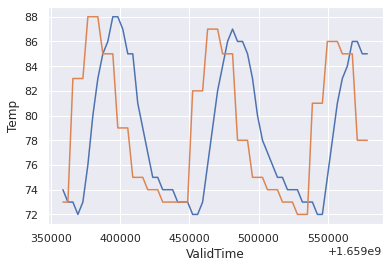

In [17]:
sns.set_theme(style="darkgrid")

sns.lineplot(data=comp_df, x="ValidTime", y='Temp')
sns.lineplot(data=comp_df, x="ValidTime", y='TempPFM')

<AxesSubplot:xlabel='ValidTime', ylabel='DewP'>

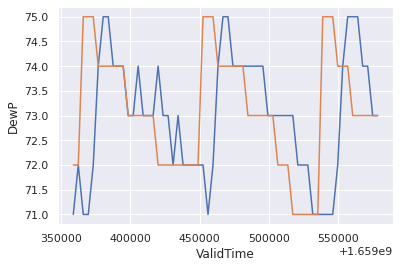

In [18]:
sns.lineplot(data=comp_df, x="ValidTime", y='DewP')
sns.lineplot(data=comp_df, x="ValidTime", y='DewPPFM')

<AxesSubplot:xlabel='ValidTime', ylabel='RH'>

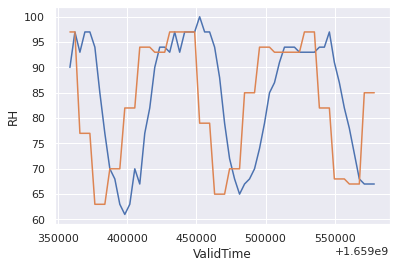

In [19]:
sns.lineplot(data=comp_df, x="ValidTime", y='RH')
sns.lineplot(data=comp_df, x="ValidTime", y='RHPFM')